## Generation analysis

How different layers in LLaVA predict tokens during generation

1. Generate one token at a time
2. Collect what top-1 tokens all layers predicted
3. Add the actual chosen token and repeat

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from llava import LLaVA

/home/sofism/miniconda3/envs/llava-lens/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
#loading 1 image
llava = LLaVA()
llava.load_data(1)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Using `use_fast=True` but `torchvision` is not available. Falling back to the slow image processor.


Loaded pretrained model llama-7b-hf into HookedTransformer


Resolving data files:   0%|          | 0/200 [00:00<?, ?it/s]

In [3]:
max_new_tokens = 10  # max number of tokens to generate
top_k = 5            # number of top tokens

In [4]:
def generate_single_token(llava, current_inputs_embeds, top_k):
    # get the unembedding matrix
    unembed = llava.hooked_llm.W_U.to(dtype=torch.float32)
    
    # run with cache
    logits, cache = llava.hooked_llm.run_with_cache(
        current_inputs_embeds, 
        start_at_layer=0, 
        remove_batch_dim=True
    )

    # get residual stream across all layers
    resid_stack, labels = cache.accumulated_resid(layer=-1, incl_mid=True, return_labels=True)
    
    # apply layer normalization to the residual stream
    resid_stack_ln = cache.apply_ln_to_stack(resid_stack, layer=-1, pos_slice=-1)
    
    # compute token logits for each layer
    token_logits = resid_stack_ln @ unembed
    
    # get top-k predicted tokens for each layer and position
    _, topk_indices = torch.topk(token_logits, k=top_k, dim=-1)

    # decode
    step_top_tokens = [[
        [llava.tokenizer.decode([idx]) for idx in topk_indices[layer, pos]]
        for pos in range(topk_indices.shape[1])
    ] for layer in range(topk_indices.shape[0])]
    
    # get the final model prediction for next token
    next_token_logits = logits[0, -1, :]
    
    # select the token with highest probability
    next_token_id = torch.argmax(next_token_logits, dim=-1)
    
    # get embedding
    next_token_embed = llava.hooked_llm.W_E[next_token_id]
    
    return step_top_tokens, next_token_id, next_token_embed

In [5]:
def generate_tokens(llava, inputs_embeds, max_new_tokens, top_k):
    generation_analysis = []
    generated_token_ids = []
    current_inputs_embeds = inputs_embeds
    
    for i in range(max_new_tokens):
        print(f"step = {i+1}")
        
        step_top_tokens, next_token_id, next_token_embed = generate_single_token(
            llava, current_inputs_embeds, top_k
        )
        
        generation_analysis.append(step_top_tokens)
        
        generated_token_ids.append(next_token_id.item())
        
        generated_token_str = llava.tokenizer.decode([next_token_id])
        print(f"token: '{generated_token_str}' (id: {next_token_id.item()})")
        
        new_token_embed_3d = next_token_embed.unsqueeze(0).unsqueeze(0)
        current_inputs_embeds = torch.cat(
            [current_inputs_embeds, new_token_embed_3d],
            dim=1
        )
        
        torch.cuda.empty_cache()
        
        # check for end-of-sequence token
        if next_token_id.item() == 2:
            break
    
    return generation_analysis, generated_token_ids

In [6]:
def prepare_visualization_data(generation_analysis, generated_token_ids, inputs_embeds, llava):
    num_layers = len(generation_analysis[0])
    prompt_len = inputs_embeds.shape[1]
    
    token_grid = []
    match_grid = []
    
    for i, step_analysis in enumerate(generation_analysis):
        # get the actual generated token
        final_generated_token_str = llava.tokenizer.decode([generated_token_ids[i]]).strip()
        
        # calculate the position index for the current sequence length
        current_seq_len = prompt_len + i
        final_pos_idx = current_seq_len - 1
    
        # extract predictions from each layer for the final position
        step_tokens = []
        match_row = []
        for layer_idx in range(num_layers):
            # get the top prediction from this layer
            token_str = step_analysis[layer_idx][final_pos_idx][0].strip()
            step_tokens.append(token_str)
            
            # check if this layer's prediction matches the final generated token
            match_row.append(token_str == final_generated_token_str)
            
        token_grid.append(step_tokens)
        match_grid.append(match_row)
    
    token_grid = np.array(token_grid).T
    match_grid = np.array(match_grid).T
    
    # plotting every 2nd layer
    layer_indices = np.arange(0, num_layers, 2)
    token_grid = token_grid[layer_indices, :]
    match_grid = match_grid[layer_indices, :]
    
    return token_grid, match_grid, layer_indices

In [7]:
def create_visualization(token_grid, match_grid, layer_indices, question, image_name, llava):
    num_steps = token_grid.shape[1]
    
    colors = np.where(match_grid, '#FFD700', '#E0E0E0')
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for y in range(token_grid.shape[0]):
        for x in range(token_grid.shape[1]):
            ax.add_patch(plt.Rectangle((x - 0.5, y - 0.5), 1, 1, color=colors[y, x]))
            
            text_color = 'black'
            ax.text(
                x, y,
                f"'{token_grid[y, x]}'",
                ha='center',
                va='center',
                fontsize=8,
                color=text_color,
                fontweight='bold' if match_grid[y, x] else 'normal'
            )
    
    ax.set_xlabel("Generation step", fontsize=12)
    ax.set_ylabel("Layer", fontsize=12)
    ax.set_title(f"Predicted Tokens for question: {question}", fontsize=14, pad=10)
    
    ax.set_xticks(np.arange(num_steps))
    ax.set_yticks(np.arange(len(layer_indices)))
    ax.set_yticklabels([f"Layer {i}" for i in layer_indices])
    
    ax.set_xlim(-0.5, num_steps - 0.5)
    ax.set_ylim(len(layer_indices) - 0.5, -0.5)
    
    plt.tight_layout()
    plt.savefig(llava.results_dir / f"{image_name}_token_generation.png", bbox_inches='tight')
    plt.show()

In [8]:
def analyze_sample(llava, image, question, image_name, max_new_tokens, top_k):
    inputs_embeds, _, _, _, _ = llava.get_llm_input_embeddings(image, question)
    
    generation_analysis, generated_token_ids = generate_tokens(
        llava, inputs_embeds, max_new_tokens, top_k
    )
    
    full_generated_text = llava.tokenizer.decode(generated_token_ids)
    print(f"full text: {full_generated_text}")
    
    token_grid, match_grid, layer_indices = prepare_visualization_data(
        generation_analysis, generated_token_ids, inputs_embeds, llava
    )
    create_visualization(token_grid, match_grid, layer_indices, question, image_name, llava)

step = 1
token: 'The' (id: 450)
step = 2
token: 'cat' (id: 6635)
step = 3
token: 'is' (id: 338)
step = 4
token: 'black' (id: 4628)
step = 5
token: '.' (id: 29889)
step = 6
token: '</s>' (id: 2)
full text: The cat is black.</s>


/tmp/ipykernel_58385/2142740396.py:34: UserWarning: Glyph 10134 (\N{HEAVY MINUS SIGN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_58385/2142740396.py:34: UserWarning: Glyph 33394 (\N{CJK UNIFIED IDEOGRAPH-8272}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_58385/2142740396.py:35: UserWarning: Glyph 10134 (\N{HEAVY MINUS SIGN}) missing from font(s) DejaVu Sans.
  plt.savefig(llava.results_dir / f"{image_name}_token_generation.png", bbox_inches='tight')
/tmp/ipykernel_58385/2142740396.py:35: UserWarning: Glyph 33394 (\N{CJK UNIFIED IDEOGRAPH-8272}) missing from font(s) DejaVu Sans.
  plt.savefig(llava.results_dir / f"{image_name}_token_generation.png", bbox_inches='tight')
/home/sofism/miniconda3/envs/llava-lens/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10134 (\N{HEAVY MINUS SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/sofism/miniconda3/envs/llava-lens/lib

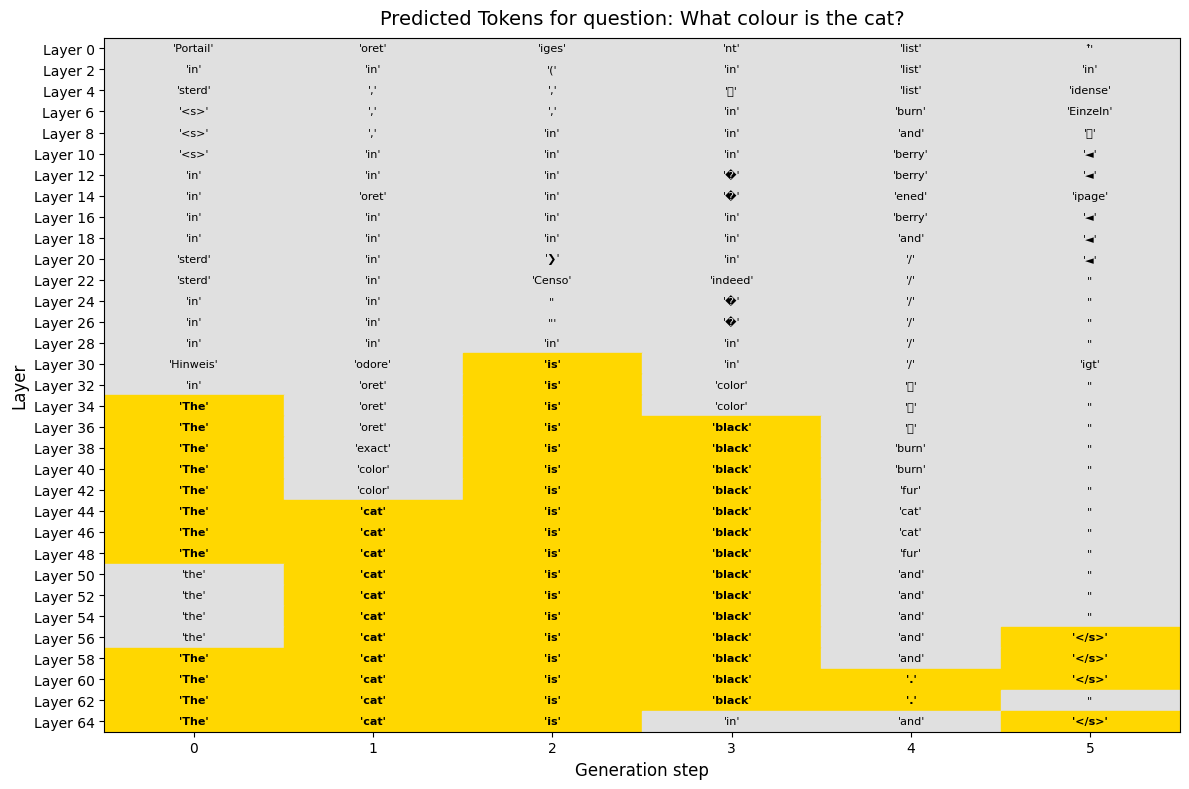

step = 1
token: 'The' (id: 450)
step = 2
token: 'dog' (id: 11203)
step = 3
token: 'is' (id: 338)
step = 4
token: 'black' (id: 4628)
step = 5
token: 'and' (id: 322)
step = 6
token: 'white' (id: 4796)
step = 7
token: '.' (id: 29889)
step = 8
token: '</s>' (id: 2)
full text: The dog is black and white.</s>


/tmp/ipykernel_58385/2142740396.py:34: UserWarning: Glyph 10134 (\N{HEAVY MINUS SIGN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_58385/2142740396.py:34: UserWarning: Glyph 33394 (\N{CJK UNIFIED IDEOGRAPH-8272}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_58385/2142740396.py:35: UserWarning: Glyph 10134 (\N{HEAVY MINUS SIGN}) missing from font(s) DejaVu Sans.
  plt.savefig(llava.results_dir / f"{image_name}_token_generation.png", bbox_inches='tight')
/tmp/ipykernel_58385/2142740396.py:35: UserWarning: Glyph 33394 (\N{CJK UNIFIED IDEOGRAPH-8272}) missing from font(s) DejaVu Sans.
  plt.savefig(llava.results_dir / f"{image_name}_token_generation.png", bbox_inches='tight')
/home/sofism/miniconda3/envs/llava-lens/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10134 (\N{HEAVY MINUS SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/sofism/miniconda3/envs/llava-lens/lib

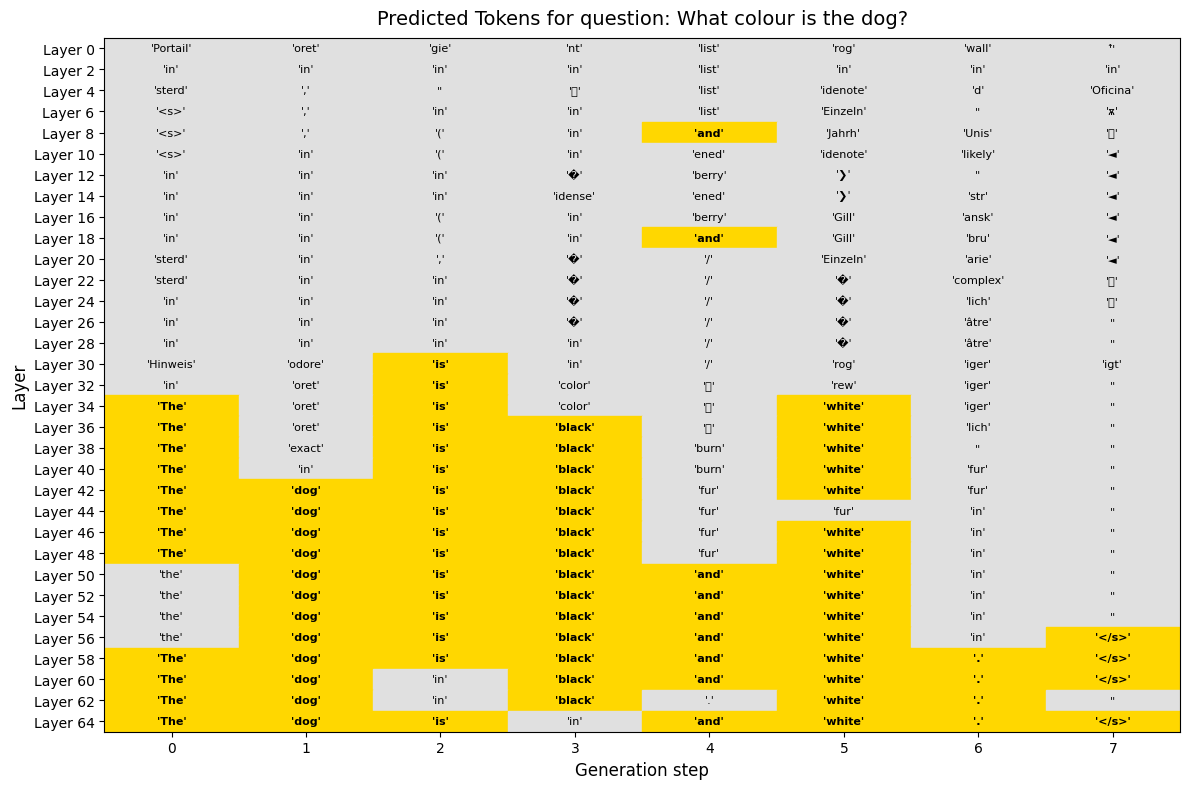

In [9]:
for image, question, image_name in llava.dataset:
    analyze_sample(llava, image, question, image_name, max_new_tokens, top_k)